#**Практическое задание №1**

Установка необходимых пакетов:

In [3]:
!pip install -q tqdm
!pip install --upgrade --no-cache-dir gdown

Монтирование Вашего Google Drive к текущему окружению:

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Константы, которые пригодятся в коде далее, и ссылки (gdrive идентификаторы) на предоставляемые наборы данных:

In [5]:
EVALUATE_ONLY = False
TEST_ON_LARGE_DATASET = True
TISSUE_CLASSES = ('ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM')
DATASETS_LINKS = {
    'train': '1XtQzVQ5XbrfxpLHJuL0XBGJ5U7CS-cLi',
    'train_small': '1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR',
    'train_tiny': '1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui',
    'test': '1RfPou3pFKpuHDJZ-D9XDFzgvwpUBFlDr',
    'test_small': '1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI',
    'test_tiny': '1viiB0s041CNsAK4itvX8PnYthJ-MDnQc'
}

Импорт необходимых зависимостей:

In [6]:
from pathlib import Path
import numpy as np
from typing import List
from tqdm.notebook import tqdm
from time import sleep
from PIL import Image
import IPython.display
from sklearn.metrics import balanced_accuracy_score
import gdown

---
### Класс Dataset

Предназначен для работы с наборами данных, обеспечивает чтение изображений и соответствующих меток, а также формирование пакетов (батчей).

In [7]:
class Dataset:

    def __init__(self, name):
        self.name = name
        self.is_loaded = False
        url = f"https://drive.google.com/uc?export=download&confirm=pbef&id={DATASETS_LINKS[name]}"
        output = f'{name}.npz'
        gdown.download(url, output, quiet=False)
        print(f'Loading dataset {self.name} from npz.')
        np_obj = np.load(f'{name}.npz')
        self.images = np_obj['data']
        self.labels = np_obj['labels']
        self.n_files = self.images.shape[0]
        self.is_loaded = True
        print(f'Done. Dataset {name} consists of {self.n_files} images.')

    def image(self, i):
        # read i-th image in dataset and return it as numpy array
        if self.is_loaded:
            return self.images[i, :, :, :]

    def images_seq(self, n=None):
        # sequential access to images inside dataset (is needed for testing)
        for i in range(self.n_files if not n else n):
            yield self.image(i)

    def random_image_with_label(self):
        # get random image with label from dataset
        i = np.random.randint(self.n_files)
        return self.image(i), self.labels[i]

    def random_batch_with_labels(self, n):
        # create random batch of images with labels (is needed for training)
        indices = np.random.choice(self.n_files, n)
        imgs = []
        for i in indices:
            img = self.image(i)
            imgs.append(self.image(i))
        logits = np.array([self.labels[i] for i in indices])
        return np.stack(imgs), logits

    def image_with_label(self, i: int):
        # return i-th image with label from dataset
        return self.image(i), self.labels[i]

### Пример использвания класса Dataset
Загрузим обучающий набор данных, получим произвольное изображение с меткой. После чего визуализируем изображение, выведем метку. В будущем, этот кусок кода можно закомментировать или убрать.

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1I-2ZOuXLd4QwhZQQltp817Kn3J0Xgbui
To: /content/train_tiny.npz
100%|██████████| 105M/105M [00:03<00:00, 28.1MB/s] 


Loading dataset train_tiny from npz.
Done. Dataset train_tiny consists of 900 images.

Got numpy array of shape (224, 224, 3), and label with code 3.
Label code corresponds to LYM class.


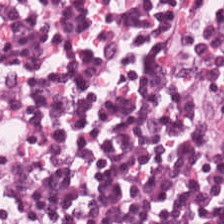

In [8]:
d_train_tiny = Dataset('train_tiny')

img, lbl = d_train_tiny.random_image_with_label()
print()
print(f'Got numpy array of shape {img.shape}, and label with code {lbl}.')
print(f'Label code corresponds to {TISSUE_CLASSES[lbl]} class.')

pil_img = Image.fromarray(img)
IPython.display.display(pil_img)

---
### Класс Metrics

Реализует метрики точности, используемые для оценивания модели:
1. точность,
2. сбалансированную точность.

In [9]:
class Metrics:

    @staticmethod
    def accuracy(gt: List[int], pred: List[int]):
        assert len(gt) == len(pred), 'gt and prediction should be of equal length'
        return sum(int(i[0] == i[1]) for i in zip(gt, pred)) / len(gt)

    @staticmethod
    def accuracy_balanced(gt: List[int], pred: List[int]):
        return balanced_accuracy_score(gt, pred)

    @staticmethod
    def print_all(gt: List[int], pred: List[int], info: str):
        print(f'metrics for {info}:')
        print('\t accuracy {:.4f}:'.format(Metrics.accuracy(gt, pred)))
        print('\t balanced accuracy {:.4f}:'.format(Metrics.accuracy_balanced(gt, pred)))

---
### Класс Model

Класс, хранящий в себе всю информацию о модели.

Вам необходимо реализовать методы save, load для сохранения и заргрузки модели. Особенно актуально это будет во время тестирования на дополнительных наборах данных.

> *Пожалуйста, убедитесь, что сохранение и загрузка модели работает корректно. Для этого обучите модель, протестируйте, сохраните ее в файл, перезапустите среду выполнения, загрузите обученную модель из файла, вновь протестируйте ее на тестовой выборке и убедитесь в том, что получаемые метрики совпадают с полученными для тестовой выбрки ранее.*


Также, Вы можете реализовать дополнительные функции, такие как:
1. валидацию модели на части обучающей выборки;
2. использование кроссвалидации;
3. автоматическое сохранение модели при обучении;
4. загрузку модели с какой-то конкретной итерации обучения (если используется итеративное обучение);
5. вывод различных показателей в процессе обучения (например, значение функции потерь на каждой эпохе);
6. построение графиков, визуализирующих процесс обучения (например, график зависимости функции потерь от номера эпохи обучения);
7. автоматическое тестирование на тестовом наборе/наборах данных после каждой эпохи обучения (при использовании итеративного обучения);
8. автоматический выбор гиперпараметров модели во время обучения;
9. сохранение и визуализацию результатов тестирования;
10. Использование аугментации и других способов синтетического расширения набора данных (дополнительным плюсом будет обоснование необходимости и обоснование выбора конкретных типов аугментации)
11. и т.д.

Полный список опций и дополнений приведен в презентации с описанием задания.

При реализации дополнительных функций допускается добавление параметров в существующие методы и добавление новых методов в класс модели.

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import os
import gdown
import numpy as np

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 9)
        )

    def forward(self, x):
        x = self.layers(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def save(self, name: str):
        save_directory = '/content/drive/MyDrive/DP'
        os.makedirs(save_directory, exist_ok=True)
        save_path = os.path.join(save_directory, f'{name}.pth')
        torch.save(self.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    def load(self, name: str):
        name_to_id_dict = {
            "best": "1-6TAam-GOJGzqGKc54A4DBHQrEbwiNFF"
        }

        if name not in name_to_id_dict:
            raise ValueError(f"Unknown model name '{name}'. Available: {list(name_to_id_dict.keys())}")

        file_id = name_to_id_dict[name]
        output = f"{name}.pth"
        gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)

        self.load_state_dict(torch.load(output, map_location=torch.device('cpu')))
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)
        self.eval()
        print(f"Model loaded from {output}")


    def normalize_inputs(self, images, mean, std):
        mean = torch.tensor(mean).view(1, -1, 1, 1)
        std = torch.tensor(std).view(1, -1, 1, 1)
        normalized_images = (images - mean) / std
        return normalized_images

    def train_model(self, dataset, batch_size=32, num_epochs=60, learning_rate=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        print(f"Training on: {device}")
        loss_history = []
        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            total_batches = dataset.n_files // batch_size

            for _ in tqdm(range(total_batches), desc=f"Epoch {epoch+1}/{num_epochs}"):
                inputs, labels = dataset.random_batch_with_labels(batch_size)
                inputs = torch.tensor(inputs, dtype=torch.float32).permute(0, 3, 1, 2)
                labels = torch.tensor(labels, dtype=torch.long)

                inputs = self.normalize_inputs(inputs, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            loss_history.append(running_loss / total_batches)
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / total_batches:.4f}")

        return loss_history, num_epochs

    def test_on_dataset(self, dataset, limit=None):
        self.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(device)

        predictions = []
        total_files = dataset.n_files if not limit else int(dataset.n_files * limit)
        with torch.no_grad():
            for img in tqdm(dataset.images_seq(total_files), total=total_files):
                inputs = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
                inputs = self.normalize_inputs(inputs, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                inputs = inputs.to(device)
                outputs = self(inputs)
                _, predicted = torch.max(outputs, 1)
                predictions.append(predicted.item())
        return predictions

    def test_on_image(self, img: np.ndarray):
        self.eval()
        with torch.no_grad():
            img_tensor = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
            img_tensor = self.normalize_inputs(img_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            outputs = self(img_tensor)
            _, predicted_class = torch.max(outputs, 1)
            return predicted_class.item()


---
### Классификация изображений

Используя введенные выше классы можем перейти уже непосредственно к обучению модели классификации изображений. Пример общего пайплайна решения задачи приведен ниже. Вы можете его расширять и улучшать. В данном примере используются наборы данных 'train_small' и 'test_small'.

In [30]:
d_train = Dataset('train_small')
d_test = Dataset('test_small')


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1qd45xXfDwdZjktLFwQb-et-mAaFeCzOR
To: /content/train_small.npz
100%|██████████| 841M/841M [00:15<00:00, 55.0MB/s]


Loading dataset train_small from npz.
Done. Dataset train_small consists of 7200 images.


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1wbRsog0n7uGlHIPGLhyN-PMeT2kdQ2lI
To: /content/test_small.npz
100%|██████████| 211M/211M [00:05<00:00, 39.8MB/s]


Loading dataset test_small from npz.
Done. Dataset test_small consists of 1800 images.


In [77]:
model = Model()
if not EVALUATE_ONLY:
    loss_list, num_epochs = model.train_model(d_train)
    model.save('best')
else:
    #todo: your link goes here
    model.load('best')

Training on: cuda


Epoch 1/60: 100%|██████████| 225/225 [00:31<00:00,  7.06it/s]


Epoch [1/60], Loss: 1.1906


Epoch 2/60: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]


Epoch [2/60], Loss: 0.8765


Epoch 3/60: 100%|██████████| 225/225 [00:31<00:00,  7.17it/s]


Epoch [3/60], Loss: 0.7723


Epoch 4/60: 100%|██████████| 225/225 [00:30<00:00,  7.39it/s]


Epoch [4/60], Loss: 0.6634


Epoch 5/60: 100%|██████████| 225/225 [00:30<00:00,  7.44it/s]


Epoch [5/60], Loss: 0.5684


Epoch 6/60: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]


Epoch [6/60], Loss: 0.4913


Epoch 7/60: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


Epoch [7/60], Loss: 0.4517


Epoch 8/60: 100%|██████████| 225/225 [00:30<00:00,  7.31it/s]


Epoch [8/60], Loss: 0.4099


Epoch 9/60: 100%|██████████| 225/225 [00:30<00:00,  7.34it/s]


Epoch [9/60], Loss: 0.3219


Epoch 10/60: 100%|██████████| 225/225 [00:29<00:00,  7.54it/s]


Epoch [10/60], Loss: 0.3270


Epoch 11/60: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


Epoch [11/60], Loss: 0.3030


Epoch 12/60: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]


Epoch [12/60], Loss: 0.2785


Epoch 13/60: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


Epoch [13/60], Loss: 0.2539


Epoch 14/60: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]


Epoch [14/60], Loss: 0.2427


Epoch 15/60: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]


Epoch [15/60], Loss: 0.2236


Epoch 16/60: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]


Epoch [16/60], Loss: 0.2322


Epoch 17/60: 100%|██████████| 225/225 [00:30<00:00,  7.46it/s]


Epoch [17/60], Loss: 0.2285


Epoch 18/60: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]


Epoch [18/60], Loss: 0.2090


Epoch 19/60: 100%|██████████| 225/225 [00:32<00:00,  7.02it/s]


Epoch [19/60], Loss: 0.1794


Epoch 20/60: 100%|██████████| 225/225 [00:32<00:00,  6.98it/s]


Epoch [20/60], Loss: 0.1923


Epoch 21/60: 100%|██████████| 225/225 [00:32<00:00,  6.89it/s]


Epoch [21/60], Loss: 0.1810


Epoch 22/60: 100%|██████████| 225/225 [00:32<00:00,  6.91it/s]


Epoch [22/60], Loss: 0.1588


Epoch 23/60: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]


Epoch [23/60], Loss: 0.1503


Epoch 24/60: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]


Epoch [24/60], Loss: 0.1393


Epoch 25/60: 100%|██████████| 225/225 [00:30<00:00,  7.27it/s]


Epoch [25/60], Loss: 0.1431


Epoch 26/60: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]


Epoch [26/60], Loss: 0.1534


Epoch 27/60: 100%|██████████| 225/225 [00:30<00:00,  7.40it/s]


Epoch [27/60], Loss: 0.1417


Epoch 28/60: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


Epoch [28/60], Loss: 0.1381


Epoch 29/60: 100%|██████████| 225/225 [00:30<00:00,  7.26it/s]


Epoch [29/60], Loss: 0.1234


Epoch 30/60: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]


Epoch [30/60], Loss: 0.1241


Epoch 31/60: 100%|██████████| 225/225 [00:31<00:00,  7.13it/s]


Epoch [31/60], Loss: 0.1393


Epoch 32/60: 100%|██████████| 225/225 [00:30<00:00,  7.32it/s]


Epoch [32/60], Loss: 0.1111


Epoch 33/60: 100%|██████████| 225/225 [00:30<00:00,  7.35it/s]


Epoch [33/60], Loss: 0.0955


Epoch 34/60: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]


Epoch [34/60], Loss: 0.1070


Epoch 35/60: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]


Epoch [35/60], Loss: 0.1122


Epoch 36/60: 100%|██████████| 225/225 [00:31<00:00,  7.04it/s]


Epoch [36/60], Loss: 0.0953


Epoch 37/60: 100%|██████████| 225/225 [00:30<00:00,  7.29it/s]


Epoch [37/60], Loss: 0.1173


Epoch 38/60: 100%|██████████| 225/225 [00:30<00:00,  7.33it/s]


Epoch [38/60], Loss: 0.0940


Epoch 39/60: 100%|██████████| 225/225 [00:30<00:00,  7.30it/s]


Epoch [39/60], Loss: 0.0914


Epoch 40/60: 100%|██████████| 225/225 [00:30<00:00,  7.28it/s]


Epoch [40/60], Loss: 0.0947


Epoch 41/60: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


Epoch [41/60], Loss: 0.0831


Epoch 42/60: 100%|██████████| 225/225 [00:31<00:00,  7.08it/s]


Epoch [42/60], Loss: 0.0857


Epoch 43/60: 100%|██████████| 225/225 [00:30<00:00,  7.41it/s]


Epoch [43/60], Loss: 0.0829


Epoch 44/60: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]


Epoch [44/60], Loss: 0.0845


Epoch 45/60: 100%|██████████| 225/225 [00:30<00:00,  7.43it/s]


Epoch [45/60], Loss: 0.0703


Epoch 46/60: 100%|██████████| 225/225 [00:29<00:00,  7.58it/s]


Epoch [46/60], Loss: 0.0861


Epoch 47/60: 100%|██████████| 225/225 [00:30<00:00,  7.36it/s]


Epoch [47/60], Loss: 0.0786


Epoch 48/60: 100%|██████████| 225/225 [00:31<00:00,  7.09it/s]


Epoch [48/60], Loss: 0.0734


Epoch 49/60: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


Epoch [49/60], Loss: 0.0687


Epoch 50/60: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


Epoch [50/60], Loss: 0.0756


Epoch 51/60: 100%|██████████| 225/225 [00:29<00:00,  7.59it/s]


Epoch [51/60], Loss: 0.0496


Epoch 52/60: 100%|██████████| 225/225 [00:30<00:00,  7.48it/s]


Epoch [52/60], Loss: 0.0660


Epoch 53/60: 100%|██████████| 225/225 [00:30<00:00,  7.49it/s]


Epoch [53/60], Loss: 0.0672


Epoch 54/60: 100%|██████████| 225/225 [00:31<00:00,  7.22it/s]


Epoch [54/60], Loss: 0.0609


Epoch 55/60: 100%|██████████| 225/225 [00:31<00:00,  7.23it/s]


Epoch [55/60], Loss: 0.0588


Epoch 56/60: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


Epoch [56/60], Loss: 0.0509


Epoch 57/60: 100%|██████████| 225/225 [00:30<00:00,  7.45it/s]


Epoch [57/60], Loss: 0.0529


Epoch 58/60: 100%|██████████| 225/225 [00:30<00:00,  7.38it/s]


Epoch [58/60], Loss: 0.0599


Epoch 59/60: 100%|██████████| 225/225 [00:31<00:00,  7.25it/s]


Epoch [59/60], Loss: 0.0790


Epoch 60/60: 100%|██████████| 225/225 [00:30<00:00,  7.42it/s]

Epoch [60/60], Loss: 0.0518
Model saved to /content/drive/MyDrive/DP/best.pth


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Пример тестирования модели на части набора данных:

In [28]:
model = Model()
model.load('best')

Downloading...
From: https://drive.google.com/uc?id=1-6TAam-GOJGzqGKc54A4DBHQrEbwiNFF
To: /content/best.pth
100%|██████████| 18.4M/18.4M [00:00<00:00, 83.0MB/s]

Model loaded from best.pth



<ipython-input-27-d54745568779>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(output, map_location=torch.device('cpu')))


In [31]:
# evaluating model on 10% of test dataset
pred_1 = model.test_on_dataset(d_test, limit=0.1)
Metrics.print_all(d_test.labels[:len(pred_1)], pred_1, '10% of test')

100%|██████████| 180/180 [00:26<00:00,  6.76it/s]

metrics for 10% of test:
	 accuracy 0.9667:
	 balanced accuracy 0.9667:



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Пример тестирования модели на полном наборе данных:

In [32]:
# evaluating model on full test dataset (may take time)
if TEST_ON_LARGE_DATASET:
    pred_2 = model.test_on_dataset(d_test)
    Metrics.print_all(d_test.labels, pred_2, 'test')

100%|██████████| 1800/1800 [02:46<00:00, 10.79it/s]

metrics for test:
	 accuracy 0.9456:
	 balanced accuracy 0.9456:


Результат работы пайплайна обучения и тестирования выше тоже будет оцениваться. Поэтому не забудьте присылать на проверку ноутбук с выполнеными ячейками кода с демонстрациями метрик обучения, графиками и т.п. В этом пайплайне Вам необходимо продемонстрировать работу всех реализованных дополнений, улучшений и т.п.

<font color="red">
Настоятельно рекомендуется после получения пайплайна с полными результатами обучения экспортировать ноутбук в pdf (файл -> печать) и прислать этот pdf вместе с самим ноутбуком.
</font>

### Тестирование модели на других наборах данных

Ваша модель должна поддерживать тестирование на других наборах данных. Для удобства, Вам предоставляется набор данных test_tiny, который представляет собой малую часть (2% изображений) набора test. Ниже приведен фрагмент кода, который будет осуществлять тестирование для оценивания Вашей модели на дополнительных тестовых наборах данных.

<font color="red">
Прежде чем отсылать задание на проверку, убедитесь в работоспособности фрагмента кода ниже.
</font>

In [33]:
final_model = Model()
final_model.load('best')
d_test_tiny = Dataset('test_tiny')
pred = model.test_on_dataset(d_test_tiny)
Metrics.print_all(d_test_tiny.labels, pred, 'test-tiny')

Downloading...
From: https://drive.google.com/uc?id=1-6TAam-GOJGzqGKc54A4DBHQrEbwiNFF
To: /content/best.pth
100%|██████████| 18.4M/18.4M [00:00<00:00, 90.6MB/s]
<ipython-input-27-d54745568779>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an i

Model loaded from best.pth


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1viiB0s041CNsAK4itvX8PnYthJ-MDnQc
To: /content/test_tiny.npz
100%|██████████| 10.6M/10.6M [00:00<00:00, 62.9MB/s]


Loading dataset test_tiny from npz.
Done. Dataset test_tiny consists of 90 images.


100%|██████████| 90/90 [00:08<00:00, 10.23it/s]

metrics for test-tiny:
	 accuracy 0.8889:
	 balanced accuracy 0.8889:


Отмонтировать Google Drive.

In [ ]:
drive.flush_and_unmount()

---
# Дополнительные "полезности"

Ниже приведены примеры использования различных функций и библиотек, которые могут быть полезны при выполнении данного практического задания.

### Измерение времени работы кода

Измерять время работы какой-либо функции можно легко и непринужденно при помощи функции timeit из соответствующего модуля:

In [ ]:
import timeit

def factorial(n):
    res = 1
    for i in range(1, n + 1):
        res *= i
    return res


def f():
    return factorial(n=1000)

n_runs = 128
print(f'Function f is caluclated {n_runs} times in {timeit.timeit(f, number=n_runs)}s.')

### Scikit-learn

Для использования "классических" алгоритмов машинного обучения рекомендуется использовать библиотеку scikit-learn (https://scikit-learn.org/stable/). Пример классификации изображений цифр из набора данных MNIST при помощи классификатора SVM:

In [ ]:
# Standard scientific Python imports
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# The digits dataset
digits = datasets.load_digits()

# The data that we are interested in is made of 8x8 images of digits, let's
# have a look at the first 4 images, stored in the `images` attribute of the
# dataset.  If we were working from image files, we could load them using
# matplotlib.pyplot.imread.  Note that each image must have the same size. For these
# images, we know which digit they represent: it is given in the 'target' of
# the dataset.
_, axes = plt.subplots(2, 4)
images_and_labels = list(zip(digits.images, digits.target))
for ax, (image, label) in zip(axes[0, :], images_and_labels[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Training: %i' % label)

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

# Now predict the value of the digit on the second half:
predicted = classifier.predict(X_test)

images_and_predictions = list(zip(digits.images[n_samples // 2:], predicted))
for ax, (image, prediction) in zip(axes[1, :], images_and_predictions[:4]):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Prediction: %i' % prediction)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_test, predicted)))
disp = metrics.plot_confusion_matrix(classifier, X_test, y_test)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

### Scikit-image

Реализовывать различные операции для работы с изображениями можно как самостоятельно, работая с массивами numpy, так и используя специализированные библиотеки, например, scikit-image (https://scikit-image.org/). Ниже приведен пример использования Canny edge detector.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

### Tensorflow 2

Для создания и обучения нейросетевых моделей можно использовать фреймворк глубокого обучения Tensorflow 2. Ниже приведен пример простейшей нейроной сети, использующейся для классификации изображений из набора данных MNIST.

In [ ]:
# Install TensorFlow

import tensorflow as tf

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)

model.evaluate(x_test,  y_test, verbose=2)

<font color="red">
Для эффективной работы с моделями глубокого обучения убедитесь в том, что в текущей среде Google Colab используется аппаратный ускоритель GPU или TPU. Для смены среды выберите "среда выполнения" -> "сменить среду выполнения".
</font>

Большое количество туториалов и примеров с кодом на Tensorflow 2 можно найти на официальном сайте https://www.tensorflow.org/tutorials?hl=ru.

Также, Вам может понадобиться написать собственный генератор данных для Tensorflow 2. Скорее всего он будет достаточно простым, и его легко можно будет реализовать, используя официальную документацию TensorFlow 2. Но, на всякий случай (если не удлось сразу разобраться или хочется вникнуть в тему более глубоко), можете посмотреть следующий отличный туториал: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.

### Numba

В некоторых ситуациях, при ручных реализациях графовых алгоритмов, выполнение многократных вложенных циклов for в python можно существенно ускорить, используя JIT-компилятор Numba (https://numba.pydata.org/).
Примеры использования Numba в Google Colab можно найти тут:
1. https://colab.research.google.com/github/cbernet/maldives/blob/master/numba/numba_cuda.ipynb
2. https://colab.research.google.com/github/evaneschneider/parallel-programming/blob/master/COMPASS_gpu_intro.ipynb

> Пожалуйста, если Вы решили использовать Numba для решения этого практического задания, еще раз подумайте, нужно ли это Вам, и есть ли возможность реализовать требуемую функциональность иным способом. Используйте Numba только при реальной необходимости.



### Работа с zip архивами в Google Drive

Запаковка и распаковка zip архивов может пригодиться при сохранении и загрузки Вашей модели. Ниже приведен фрагмент кода, иллюстрирующий помещение нескольких файлов в zip архив с последующим чтением файлов из него. Все действия с директориями, файлами и архивами должны осущетвляться с примонтированным Google Drive.


Создадим 2 изображения, поместим их в директорию tmp внутри PROJECT_DIR, запакуем директорию tmp в архив tmp.zip.

In [ ]:
PROJECT_DIR = "/dev/prak_nn_1/"
arr1 = np.random.rand(100, 100, 3) * 255
arr2 = np.random.rand(100, 100, 3) * 255

img1 = Image.fromarray(arr1.astype('uint8'))
img2 = Image.fromarray(arr2.astype('uint8'))

p = "/content/drive/MyDrive/" + PROJECT_DIR

if not (Path(p) / 'tmp').exists():
    (Path(p) / 'tmp').mkdir()

img1.save(str(Path(p) / 'tmp' / 'img1.png'))
img2.save(str(Path(p) / 'tmp' / 'img2.png'))

%cd $p
!zip -r "tmp.zip" "tmp"

Распакуем архив tmp.zip в директорию tmp2 в PROJECT_DIR. Теперь внутри директории tmp2 содержится директория tmp, внутри которой находятся 2 изображения.

In [ ]:
p = "/content/drive/MyDrive/" + PROJECT_DIR
%cd $p
!unzip -uq "tmp.zip" -d "tmp2"